This mini project aims to analyze a bit of audio and add Moorer's reverb to the audio. The audio will be analyzed in time and frequency domain after each step of implementation. 

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wave 
import IPython.display as ipd

In [19]:
samplingFreq, dryMonsterSignal = wave.read('Data/monster.wav')
dryMonsterSignal = dryMonsterSignal/2**15 # Normalize
ipd.Audio(dryMonsterSignal, rate=samplingFreq) 

Above is the raw audio we will be working with in this mini project.

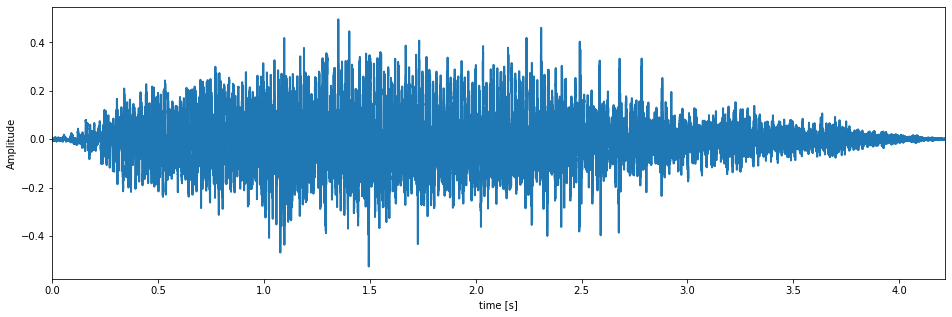

In [20]:
nData = np.size(dryMonsterSignal)
timeVector = np.arange(nData)/samplingFreq # Seconds
plt.figure(figsize=(16,5))
plt.plot(timeVector,dryMonsterSignal,linewidth=2)
plt.xlim((timeVector[0],timeVector[-1]))
plt.xlabel('time [s]'), plt.ylabel('Amplitude');

Above is the audio plotted in the time domain. 

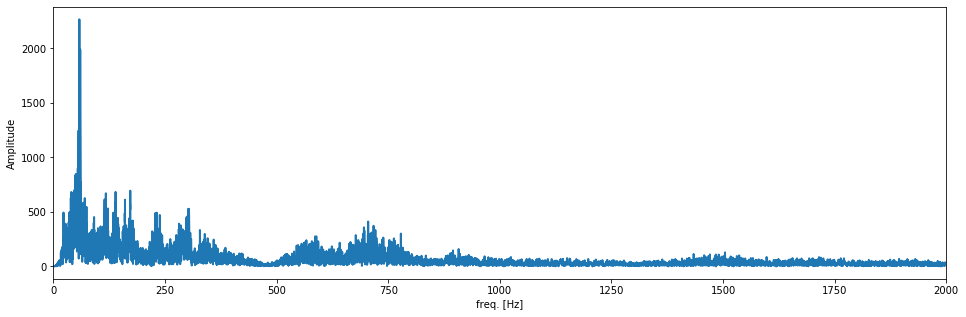

In [21]:
freqVector = np.arange(nData)*samplingFreq/nData # Hz.
# Computing DFT using the FFT algorithm.
freqResponseDry = np.fft.fft(dryMonsterSignal) 
ampSpectrumDry = np.abs(freqResponseDry)
plt.figure(figsize=(16,5))
plt.plot(freqVector,ampSpectrumDry,linewidth=2)
plt.xlim((0,2000))
plt.xlabel('freq. [Hz]'), plt.ylabel('Amplitude');

Above is the audio plotted in the frequency domain. 

Below is the low pass filter function.

In [22]:
def lpFilter(inputSignal, filterParam):
    signalLength = np.size(inputSignal)
    outputSignal = np.zeros(signalLength)
    
    for n in np.arange(signalLength):
        
        outputSignal[n] = (1 - filterParam) * inputSignal[n-1] + filterParam * outputSignal[n-1]
        
    return outputSignal

Below is the comb filter loop, also known as the plain reverberator, with a low pass filter implementation in the 'else' loop. 

In [23]:
def plainReverberator(inputSignal, delay, filterParam):
    
    signalLength = np.size(inputSignal)
    outputSignal = np.zeros(signalLength)
    
    for n in np.arange(signalLength):
        if n < delay:
            
            outputSignal[n] = inputSignal[n]
            
        else:
            
            outputSignal[n] = inputSignal[n] + filterParam*outputSignal[n-delay]
    
    outputSignal = lpFilter(outputSignal, filterParam)
            
    return outputSignal

monsterSignalWithPlainReverb = \
    plainReverberator(dryMonsterSignal, 1, 0.5) #Filter parameter/Gain can not be above 1 because of instability.
ipd.Audio(monsterSignalWithPlainReverb, rate=samplingFreq)

Above is the audio played with the plain reverberator added to the signal. 

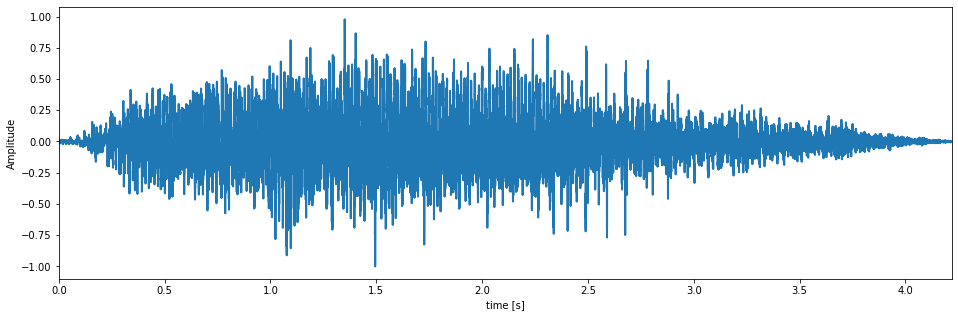

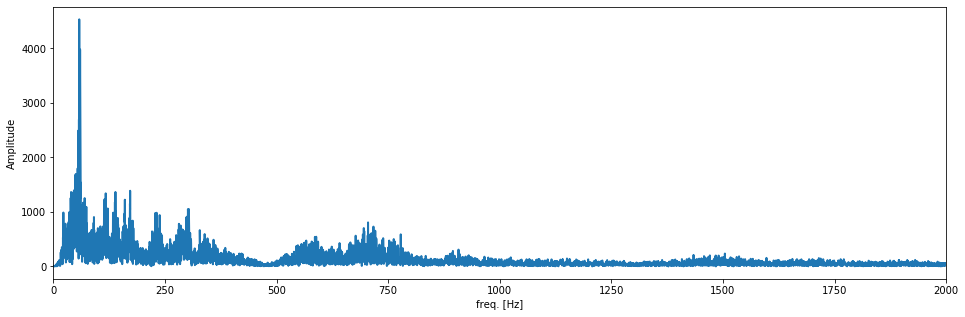

In [24]:
nData = np.size(monsterSignalWithPlainReverb)
timeVector = np.arange(nData)/samplingFreq # Seconds.
plt.figure(figsize=(16,5))
plt.plot(timeVector,monsterSignalWithPlainReverb,linewidth=2)
plt.xlim((timeVector[0],timeVector[-1]))
plt.xlabel('time [s]'), plt.ylabel('Amplitude');
freqVector = np.arange(nData)*samplingFreq/nData # Hz.
# Computing DFT using the FFT algorithm.
freqResponseDry = np.fft.fft(monsterSignalWithPlainReverb) 
ampSpectrumDry = np.abs(freqResponseDry)
plt.figure(figsize=(16,5))
plt.plot(freqVector,ampSpectrumDry,linewidth=2)
plt.xlim((0,2000))
plt.xlabel('freq. [Hz]'), plt.ylabel('Amplitude');

Above is the audio plotted in the time and frequency domain. 

Below is the all pass reverberator implementation.

In [25]:
def allpassReverberator(inputSignal, delay, apParam):
    nData = np.size(inputSignal)
    outputSignal = np.zeros(nData)
    for n in np.arange(nData):
        if n < delay:
            outputSignal[n] = inputSignal[n]
        else:
            outputSignal[n] = apParam*inputSignal[n] + inputSignal[n-delay] - \
                apParam*outputSignal[n-delay]
    return outputSignal

monsterSignalWithAllPassReverb = \
    allpassReverberator(dryMonsterSignal, 1, 0.4)
ipd.Audio(monsterSignalWithAllPassReverb, rate=samplingFreq)

Above is the audio played with the all-pass reverberator added to the signal. 

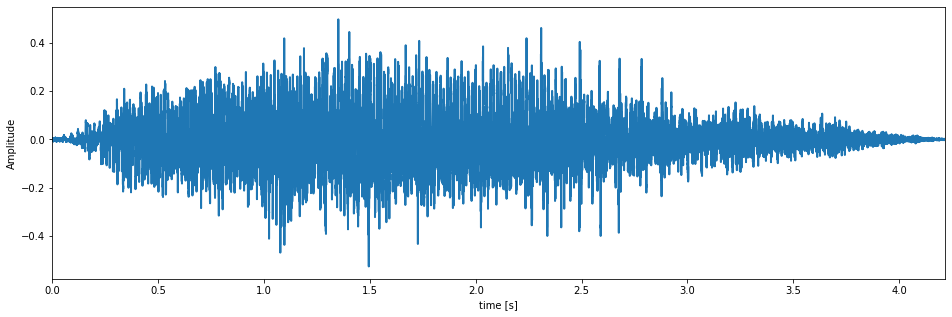

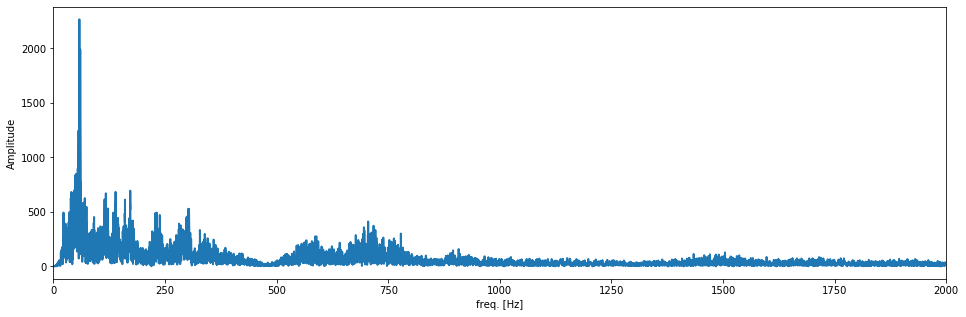

In [26]:
nData = np.size(monsterSignalWithAllPassReverb)
timeVector = np.arange(nData)/samplingFreq # Seconds.
plt.figure(figsize=(16,5))
plt.plot(timeVector,monsterSignalWithAllPassReverb,linewidth=2)
plt.xlim((timeVector[0],timeVector[-1]))
plt.xlabel('time [s]'), plt.ylabel('Amplitude');
freqVector = np.arange(nData)*samplingFreq/nData # Hz.
# Computing DFT using the FFT algorithm.
freqResponseDry = np.fft.fft(monsterSignalWithAllPassReverb) 
ampSpectrumDry = np.abs(freqResponseDry)
plt.figure(figsize=(16,5))
plt.plot(freqVector,ampSpectrumDry,linewidth=2)
plt.xlim((0,2000))
plt.xlabel('freq. [Hz]'), plt.ylabel('Amplitude');

Above is the audio plotted in the time and frequency domain. 

Below is the Moorer implementation of the classic Schroeder reverb. With various named parameters. 

In [39]:
def plainGainFromReverbTime(reverbTime, plainDelay, samplingFreq):
    nDelays = np.size(plainDelay)
    plainGains = np.zeros(nDelays)
    for ii in np.arange(nDelays):
        plainGains[ii] = 10**(-3*plainDelays[ii]/(reverbTime*samplingFreq))
    return plainGains

def moorersReverb(inputSignal, mixingParams, plainDelays, plainGains, allpassDelays, apParams):
    nData = np.size(inputSignal)
    tmpSignal = np.zeros(nData)
    # Parallel plain reverberation
    nPlainReverberators = np.size(plainDelays)
    for ii in np.arange(nPlainReverberators):
        tmpSignal = tmpSignal + \
            mixingParams[ii]*plainReverberator(inputSignal, plainDelays[ii], plainGains[ii])
    # Serial all pass reverberation
    nAllpassReverberators = np.size(allpassDelays)
    for ii in np.arange(nAllpassReverberators):
        tmpSignal = allpassReverberator(tmpSignal, allpassDelays[ii], apParams[ii])
    return tmpSignal

# Sum of mixing parameters is one because that is the desired reverberation time.
mixPara1 = 0.20
mixPara2 = 0.15
mixPara3 = 0.20
mixPara4 = 0.10
mixPara5 = 0.20
mixPara6 = 0.15

# Large delays through prime numbers, so that their non-zero output rarely overlaps.
plainD1 = 1487
plainD2 = 1319
plainD3 = 1607
plainD4 = 1583
plainD5 = 1657
plainD6 = 1789

# Small delays through prime numbers, to increase echo density but not increase reverberation time.
allPassD1 = 227
allPassD2 = 223

# Not too close to 1, because we want the reverberation to die out. 
allPassP1 = 0.70
allPassP2 = 0.80

mixingParams = np.array([mixPara1, mixPara2, mixPara3, mixPara4, mixPara5, mixPara6]) 
plainDelays = np.array([plainD1, plainD2, plainD3, plainD4, plainD5, plainD6]) 
allpassDelays = np.array([allPassD1, allPassD2]) 
apParams = np.array([allPassP1, allPassP2]) 
reverbTime = 0.01 # Seconds
plainGains = plainGainFromReverbTime(reverbTime, plainDelays, samplingFreq)
# Computing the impulse response of a room.
irLength = np.int(np.floor(reverbTime*samplingFreq))
impulse = np.r_[np.array([1]),np.zeros(irLength-1)]
impulseResponse = monsterSignalWithAllPassReverb = \
    moorersReverb(impulse, mixingParams, plainDelays, plainGains, allpassDelays, apParams)

monsterSignalWithMoorerReverb = \
    moorersReverb(dryMonsterSignal, mixingParams, plainDelays, plainGains, allpassDelays, apParams)
ipd.Audio(monsterSignalWithMoorerReverb, rate=samplingFreq)

Above is the audio played with the Moorer reverberator added to the signal. 

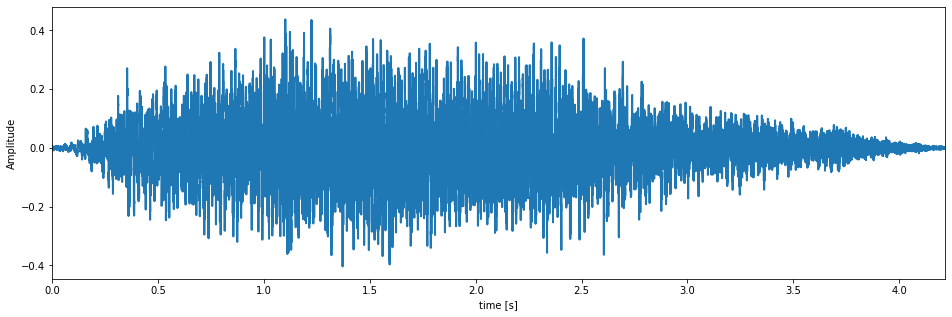

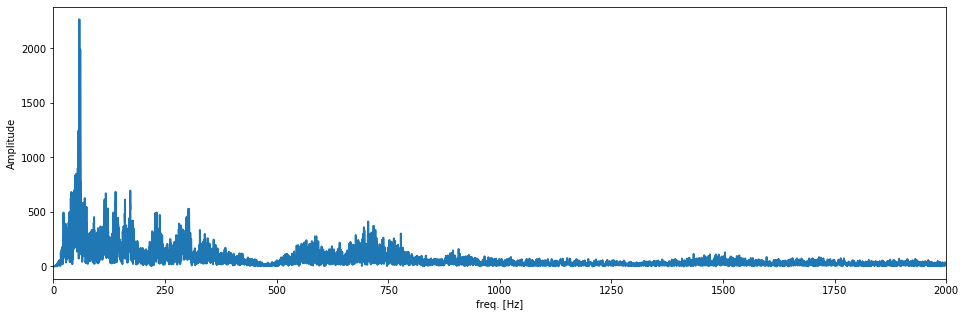

In [28]:
nData = np.size(monsterSignalWithMoorerReverb)
timeVector = np.arange(nData)/samplingFreq # Seconds.
plt.figure(figsize=(16,5))
plt.plot(timeVector,monsterSignalWithMoorerReverb,linewidth=2)
plt.xlim((timeVector[0],timeVector[-1]))
plt.xlabel('time [s]'), plt.ylabel('Amplitude');
freqVector = np.arange(nData)*samplingFreq/nData # Hz.
# Computing DFT using the FFT algorithm.
freqResponseDry = np.fft.fft(monsterSignalWithMoorerReverb) 
ampSpectrumDry = np.abs(freqResponseDry)
plt.figure(figsize=(16,5))
plt.plot(freqVector,ampSpectrumDry,linewidth=2)
plt.xlim((0,2000))
plt.xlabel('freq. [Hz]'), plt.ylabel('Amplitude');

Above is the audio plotted in the time and frequency domain. 

Another part of the Moorer implementation was the use of a tapped delay line to simulate early reflections. This is especially important for instrumental music/sounds, however for this implementation, a monsters roar, it didn't add to the quality of the reverberation. A delay 'tap' isolates part of the signal within a delay which can then be, but not necessarily, up-scaled and added with other 'taps' to form an output signal. Further implementation could include stereo panning for a more dramatic effect. 